## Init

In [35]:
import numpy as np
from matplotlib import pyplot as plt

samples = 2 ** 6
epsilon = 10**-2
xmin, xmax = -20, 20
ymin, ymax = -20, 20
zmin, zmax = -20, 20
rhomin, rhomax = 0,10
phimin, phimax = -np.pi, np.pi

phirange = np.linspace(phimin, phimax, num=samples)
rhorange = np.linspace(rhomin, rhomax, num=samples)
xrange = np.linspace(xmin, xmax, num=samples)
yrange = np.linspace(ymin, ymax, num=samples)
zrange = np.linspace(zmin, zmax, num=samples)

dx = xrange[1] - xrange[0]
dy = yrange[1] - yrange[0]
dz = zrange[1] - zrange[0]
dphi = phirange[1] - phirange[0]
drho = rhorange[1] - rhorange[0]

x, y, z = np.meshgrid(xrange, yrange, zrange, indexing='ij')

zero = np.zeros_like(x)
phi = np.atan2(y,x)
r = np.sqrt(x**2 + y**2)

orts_vec = np.array([x, y, z]) # ortsvektor (x,y)
#orts_vecXZ = np.array([x, z]) # ortsvektor (x,z)


## Helperfunctions

In [36]:
def integral(integrant,range,shape):
    out = np.zeros(shape)
    dx = range[1] - range[0]
    for x in range:
        out += integrant(x)*dx
    return out

def plot3d(x,y,z,u,v,w):
    ax = plt.figure().add_subplot(projection="3d")
    ax.quiver(x,y,z,u,v,w,length=0.5)
    ax.scatter([xmin,xmax],[ymin,ymax],[zmin,zmax],color="red")
    plt.show()
    
def plot3dVectField(points, arrows, n_arrows=5,scale=1):
    div = samples//n_arrows
    point_x,point_y,point_z  = np.array(points)[::1,::div,::div,::div]
    arrow_x,arrow_y,arrow_z = np.array(arrows)[::1,::div,::div,::div]
    plot3d(point_x,point_y,point_z,arrow_x,arrow_y,arrow_z)
    mid_index = len(point_x)//2
    fig, ((tl,tr),(ml,mr),(bl,br)) = plt.subplots(3,2,figsize=[10,10])
    
    tl.quiver(point_x[::,::,mid_index],point_y[::,::,mid_index], 
              arrow_x[::,::,mid_index],arrow_y[::,::,mid_index], 
              scale=scale)
    [tl.set_title("XY-Quiver (z=0)"),tl.set_xlabel("X"),tl.set_ylabel("Y")]
    tr.quiver(point_x[::,mid_index,::],point_z[::,mid_index,::],  
              arrow_x[::,mid_index,::],arrow_z[::,mid_index,::], 
              scale=scale)
    [tr.set_title("XZ-Quiver (y=0)"),tr.set_xlabel("X"),tr.set_ylabel("Z")]
    ml.quiver(point_y[mid_index,::,::], point_z[mid_index,::,::],  
              arrow_y[mid_index,::,::], arrow_z[mid_index,::,::], 
              scale=scale)
    [ml.set_title("ZY-Quiver (x=0)"),ml.set_xlabel("Z"),ml.set_ylabel("Y")]
    mid_index = len(arrows[0])//2
    p1=mr.imshow(arrows[0][::,::,mid_index].T,extent=(xmin,xmax,xmin,xmax))
    [mr.set_title("X-Component (z=0)"),mr.set_xlabel("X"),mr.set_ylabel("Y")]
    p2=bl.imshow(arrows[1][::,::,mid_index].T,extent=(ymin,ymax,ymin,ymax))
    [bl.set_title("Y-Component (z=0)"),bl.set_xlabel("X"),bl.set_ylabel("Y")]
    p3 = br.imshow(arrows[2][::,mid_index,::].T,extent=(zmin,zmax,zmin,zmax))
    [br.set_title("Z-Component (y=0)"),br.set_xlabel("X"),br.set_ylabel("Z")]
    fig.colorbar(p1)
    fig.colorbar(p2)
    fig.colorbar(p3)
    plt.tight_layout()
    plt.show()

# Magnetostatisches Feld eines Linienstroms

$$ \vec{r'} = \begin{bmatrix} 
                v_1 \\ 
                v_2 \\ 
                v_3 
            \end{bmatrix}
 $$

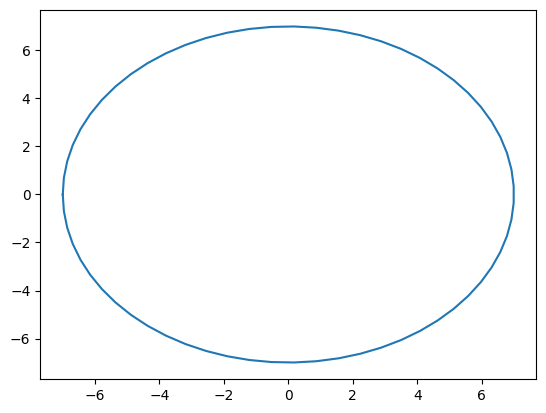

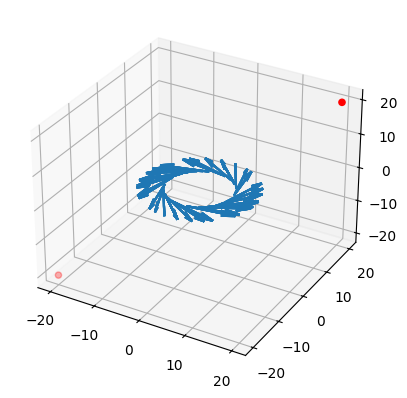

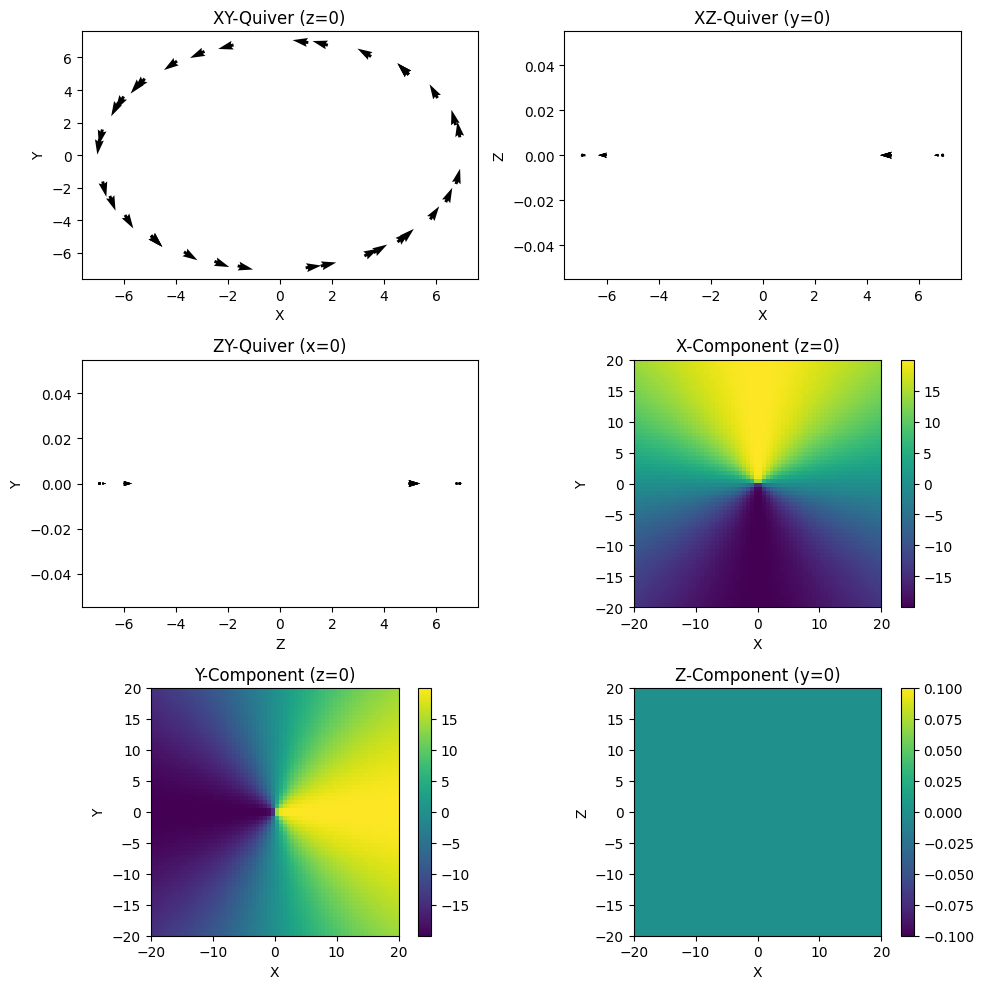

In [37]:
R = 7 # = Radius des Stroms
I = 20

def r(_phi, R): # Orts Kurve
    return R*np.array([np.cos(_phi), np.sin(_phi), np.zeros_like(_phi)])

def j(_phi, I): # Stromdichte 
    return I*np.array([-np.sin(_phi), np.cos(_phi), np.zeros_like(_phi)])

ortskurve = r(phi, R)
stromdichte = j(phi, I) # Stromdichte

kurve_x, kurve_y, _ = r(phirange, R)
plt.plot(kurve_x, kurve_y)
plt.show()
plot3dVectField(ortskurve, stromdichte, n_arrows=5, scale=500)


# Feld auf der Z - Achse (zx ebene)

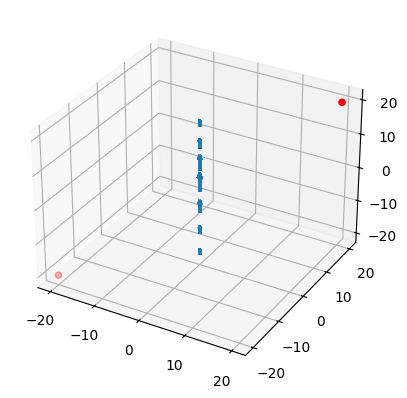

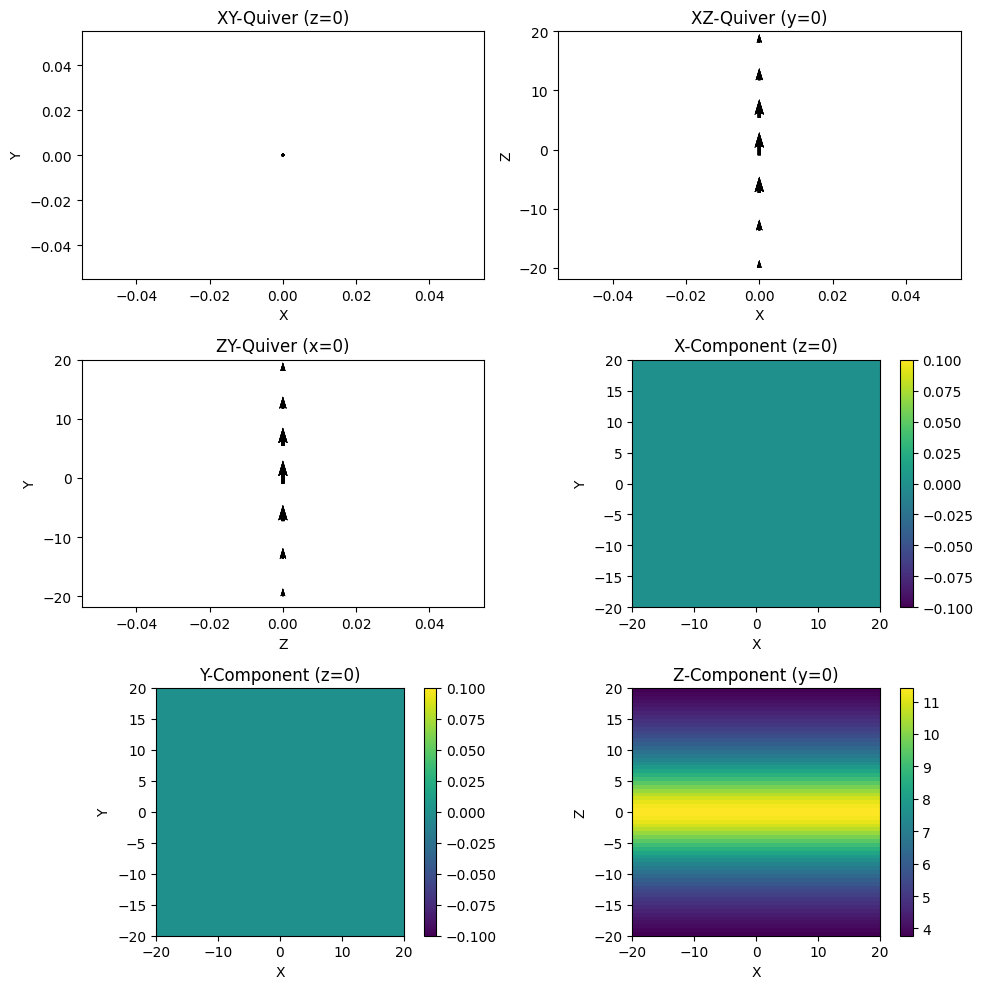

In [38]:
scalar = 160/(2*np.sqrt(R**2+z**2))
field_on_axis = np.array([zero,zero,scalar])
plot3dVectField([zero,zero,z],field_on_axis, n_arrows=6, scale=200)

# Potenzial

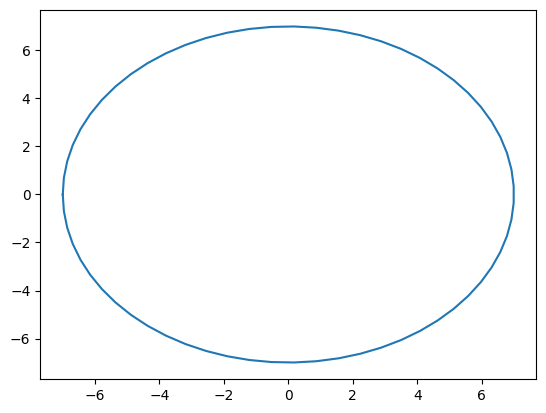

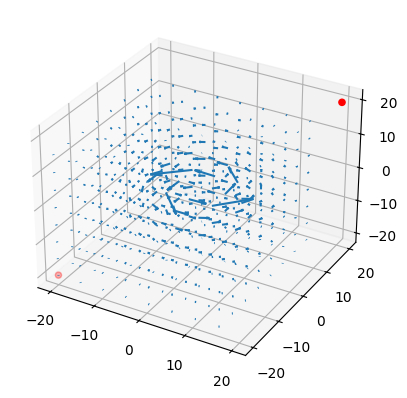

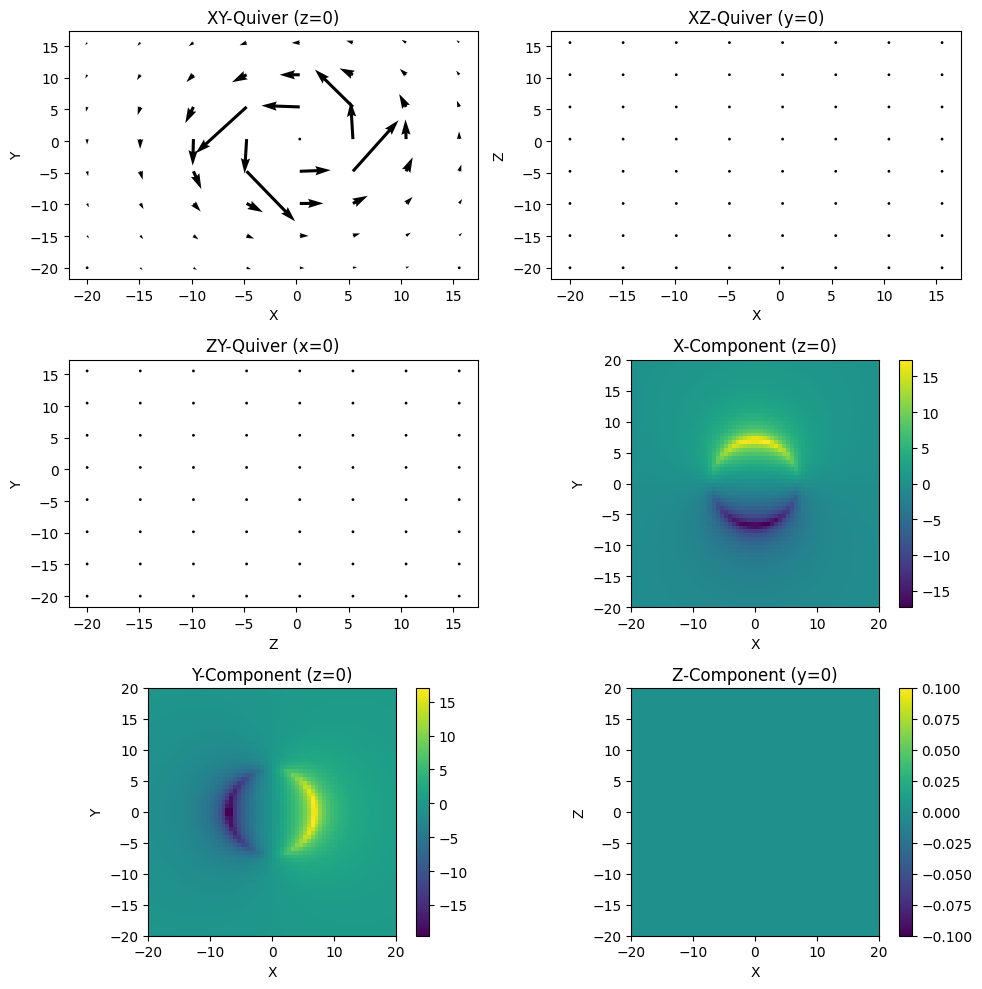

In [39]:
plt.plot(kurve_x,kurve_y)
def potenzial(r,j):
    def potenzial_integrant(_phi):
        curveN_x, curveN_y, curveN_z = r(_phi) # Ortsvektor auf der Stromkurve
        stromdichteN_x, stromdichteN_y, stromdichteN_z = j(_phi) # Stromdichte auf der Stromkurve
        distance = epsilon+np.sqrt((x-curveN_x)**2+(y-curveN_y)**2+(z-curveN_z)**2)
        return np.array([stromdichteN_x/distance,stromdichteN_y/distance,stromdichteN_z/distance])
    return integral(potenzial_integrant, phirange, orts_vec.shape)

circuit_potential = potenzial(lambda phi:r(phi,R),lambda phi:j(phi,I))
plot3dVectField([x,y,z],circuit_potential,n_arrows=8,scale=100)

# Feld


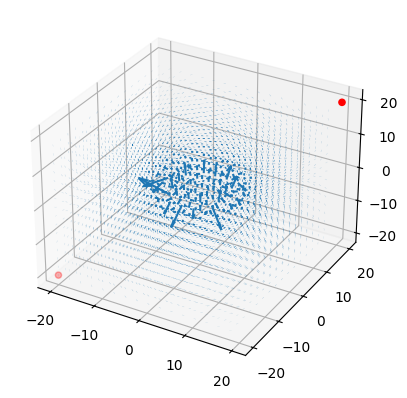

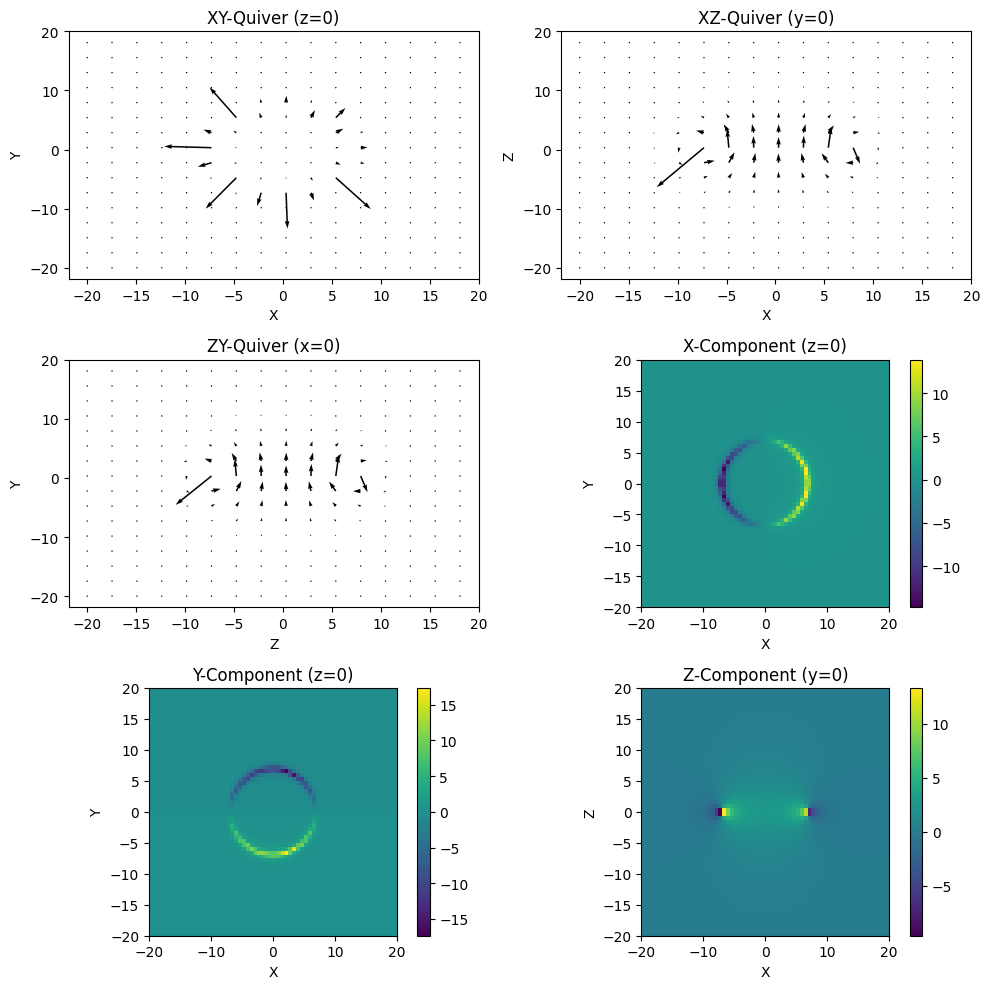

In [40]:
def field(_r,_j,parameter_range):
    def field_integrant(_phi):
        curveN_x, curveN_y, curveN_z = _r(_phi) # Ortsvektor auf der Stromkurve
        to_point = np.array([x-curveN_x, y-curveN_y, z-curveN_z])
        distance = np.linalg.norm(to_point,axis=0)
        scale = 1/(distance**3+epsilon)
        cr_x,cr_y,cr_z = np.cross(_j(_phi), to_point, axis=0)
        return np.array([cr_x*scale,cr_y*scale, cr_z*scale])
    return integral(field_integrant, parameter_range, orts_vec.shape)

circuit_field = field(lambda _phi: r(_phi,R), lambda _phi: j(_phi,I),phirange)
plot3dVectField([x,y,z],circuit_field,n_arrows=13,scale=100)

## Spule


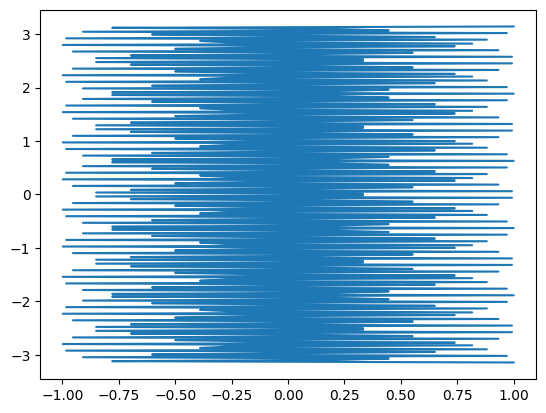

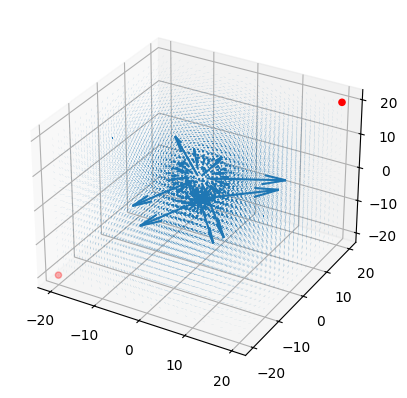

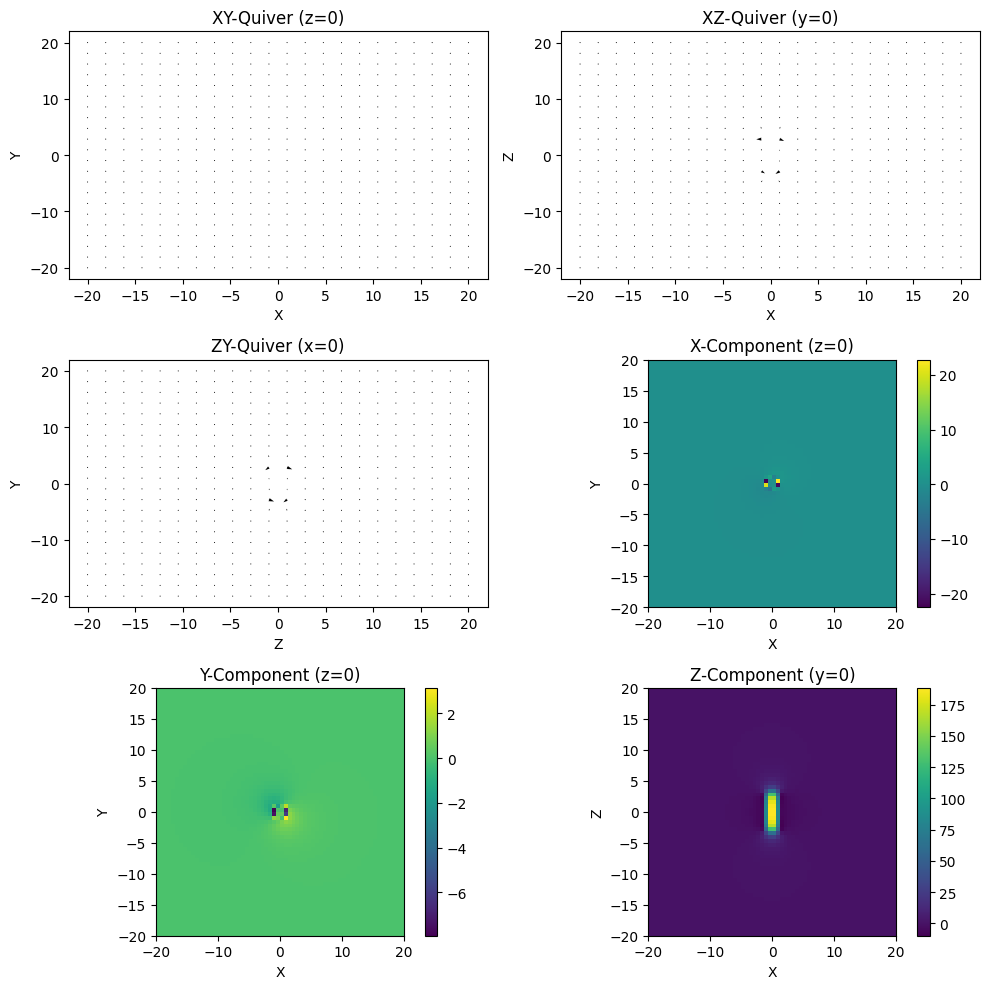

In [43]:
def spulenPlot(windungen=100,steepness=0.1,_R=1,scale=3000,I=1,detail=20 ):
    longer_phi = np.linspace(-np.pi*windungen, np.pi*windungen, num=samples*4)
    def spule(_phi):
        return np.array([_R*np.cos(_phi),_R*np.sin(_phi),_phi*steepness])
    def j_spule(_phi):
        return np.array([-_R*I*np.sin(_phi),_R*I*np.cos(_phi),I*steepness])

    kurve = spule(longer_phi)
    plt.plot(kurve[0], kurve[2])
    field_spule = field(spule,j_spule,longer_phi)
    plot3dVectField([x,y,z],field_spule,n_arrows=detail,scale=scale)
    
R = 9.5 # krumme zahl damit
#spulenPlot(1,0.01,R,50)
#spulenPlot(7,0.5,R,200)
spulenPlot(100,0.01,1,2000)




### $R-> 0$ und $R^2*I=Konst$
#### Analytische Lösung

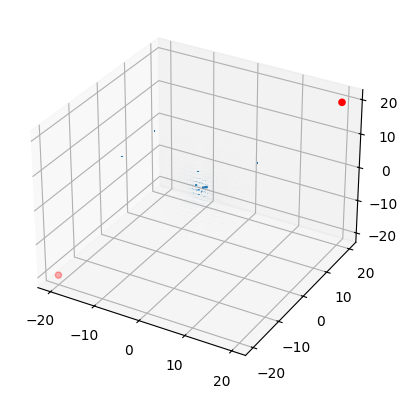

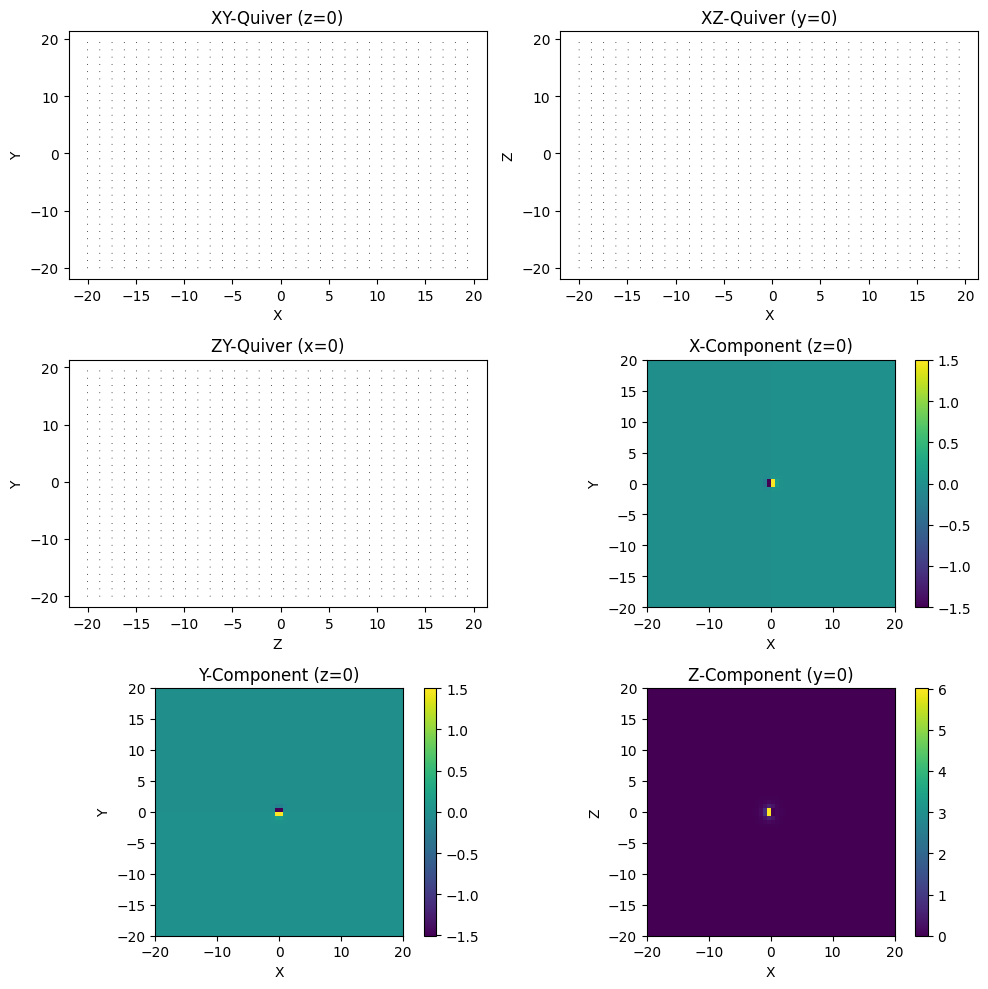

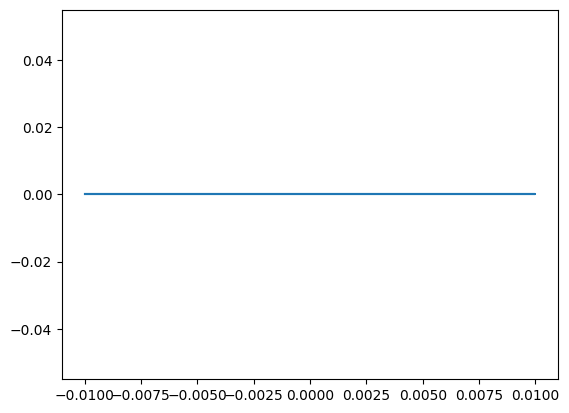

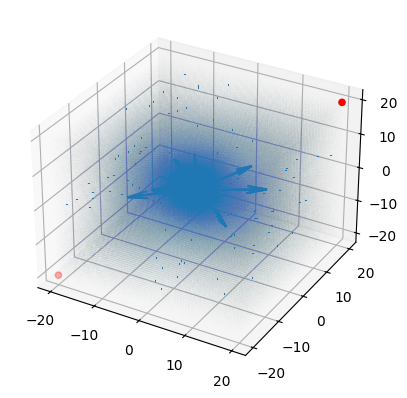

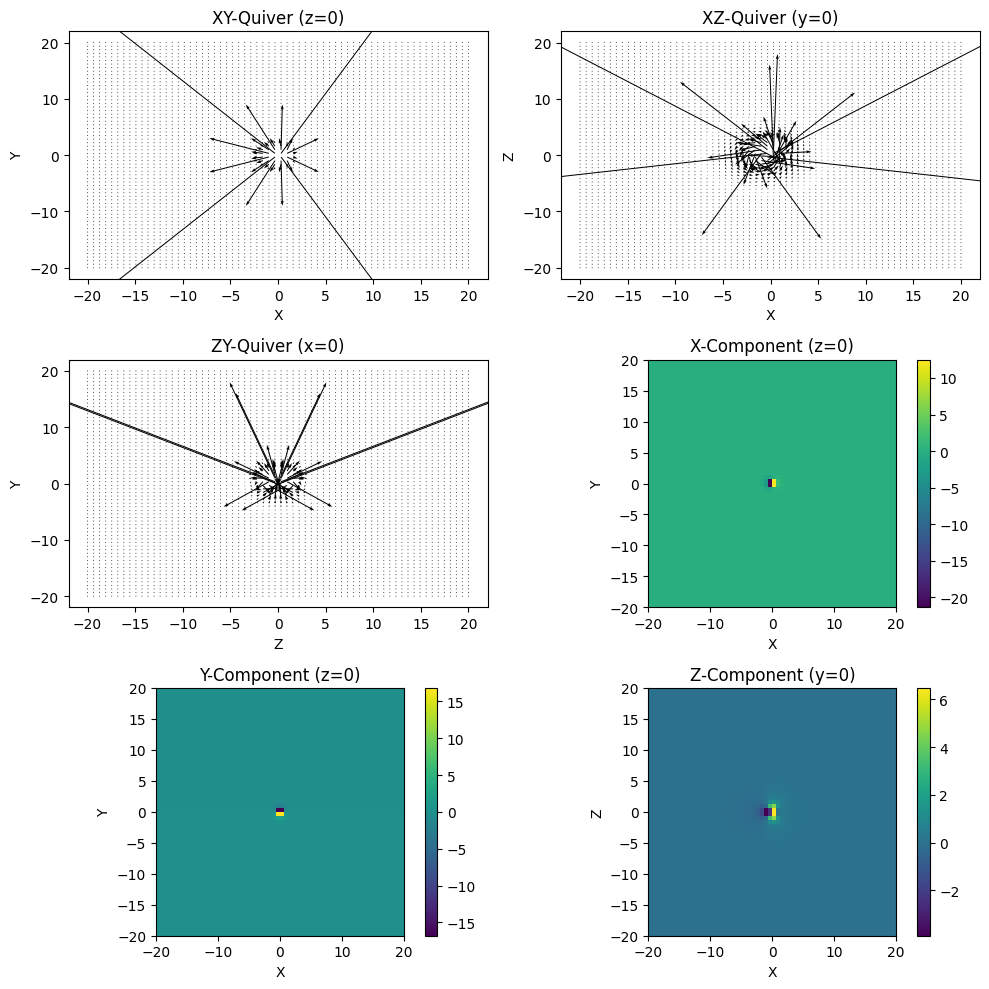

In [42]:
K = 1
abs_r = np.sqrt(x**2+y**2+z**2)
fern_field = np.array([3*x*z,3*y*z, 2*abs_r**2-6*x*y])/(4*abs_r**5)
#fern_field = np.array([zero+1,y*z,2-x*y])
plot3dVectField([x,y,z],fern_field,n_arrows=30,scale=1000)

spulenPlot(1,0,0.01, 20,I=10000,detail=51)

## 1 Analytische Lösung

Idealisierungen:
* unendlich dünner Leiter
* ringförmiger Leiter
* endlicher Radius
* Bestimmung des magnetischen Potenzials und des magnetischen Feldes nur auf der Symmetrieachse. (Sven)

### 1.1 Herleitung

* siehe Vorlesung
* magnetisches Potenzial
* magnetisches Feld
* in Zylinderkoordinaten
* Lösung auf der Achse in möglichst einfacher Form


**Poisson-Gleichung**
$$
\Delta \vec{A} = -\mu \vec{j}
$$

**Lösung**
$$
\vec{A}(\vec{r}) = \frac{\mu}{4\pi} \iiint \frac{\vec{j}(\vec{r}')}{|\vec{r} - \vec{r}'|} dV'
$$

Der Strom verläuft auf einer Kreisbahn mit Radius $R$. Die Kurve kann durch $\vec{r}(\varphi) = \begin{pmatrix} R \cos(\varphi) \\ R \sin(\varphi) \\ 0 \end{pmatrix}$ beschrieben werden. Die Stromdichte ist konstant und beträgt $I$.

Um das Magnetische Potenzial $\vec{A}$ zu berechnen, müssen wir für jeden Punkt im Raum die durchschnittliche Flussrichtung des Stroms gewichtet mit dem kehrwert des Abstandes berechnen. Dazu integrieren wir über die gesamte Kreisbahn.

$\vec{A}= \frac{\mu_0}{4\pi} \int_0^{2\pi} \frac{I}{R} \begin{pmatrix} -\sin(\varphi) \\ \cos(\varphi) \\ 0 \end{pmatrix} d\varphi$



### 1.2 Visualisierung

* magnetisches Potenzial
* $z$-Komponente des magnetischen Feldes

## 2 Numerische Lösung

### 2.1 Herleitung

* Formeln zur numerischen Berechnung in beliebigem Raumpunkt
    * magnetisches Potenzial: aus der Quellendarstellung
    * magnetisches Feld: aus dem Potenzial
* alles in Zylinderkoordinaten
* Rotationssymmetrie ausnutzen

### 2.2 Berechnung

* Wahl des Integrationsverfahrens
* Wahl des Samplings

### 2.3 Visualisierung

* magnetisches Potenzial
* alle Komponenten des magnetischen Feldes (Raphael)
* alles in Zylinderkoodinaten
* Rotationssymmetrie ausnutzen
* geeignete zweidimensionale Schnitte (zx achse y=0 y=-3)
* freie Wahl der Bibliothek zum Plotten
    * [Matplotlib](https://matplotlib.org/)
    * [Seaborn](https://seaborn.pydata.org/)
    * [Plotly](https://plotly.com/)
    * [Bokeh](https://bokeh.org/)
    * ...

## 3 Vergleich analytische und numerische Lösung

* Bestimmung des relativen Fehlers
* auf der Symmetrieachse
* magnetisches Potenzial
* $z$-Komponente des magnetischen Feldes
* Visualisierung wie bei der analytischen Lösung
* logarithmisch darstellen

## 4 Verallgemeinerung

* Spule
    * $N$ Windungen
    * Länge $L$
* magnetisches Potenzial und magnetisches Feld
* Vorgehen bei numerischer Berechnung und Visualisierung wie oben

### Fakultativ
* Ringstrom
    * Recherche analytische Lösung (falls möglich, kann kompliziert werden!)
    * Grenzübergang $R\to0$ und Vergleich mit infinitesimalem magnetischem Dipol
        * analytisch
        * numerisch
* Spule
    * Vergleich mit $N$ im Abstand $L/N$ aneinandergereihten Kreisströmen
    * Vergleich mit anderem Team: zylindrischer Permanentmagnet

## 5 Ausblick:  Zeitlich veränderlicher Strom

Idealisierungen:
* unendlich dünner Leiter
* ringförmiger Leiter
* endlicher Radius
* Bestimmung des magnetischen Potenzials und des magnetischen Feldes nur auf der Symmetrieachse.

Verallgemeinerung: *zeitlich veränderlicher* Strom
* quasistatischer Fall
* dynamischer Fall

Nur eine kurze Beschreibung dessen, was zur Bestimmung des zeitlich veränderlichen magnetischen Feldes zu tun wäre - insbesondere ein paar Worte zu den erwarteten Hürden in Bezug auf:
* Zeitkomplexität
* Speicherbedarf
* Genauigkeit